In [0]:
import tensorflow as tf
import os
os.chdir("/content/drive/Colab Notebooks/Kaggle_2018/experiments/")  # colab directory
import utils
import numpy as np
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
from scipy.ndimage import imread

In [0]:
def crop_and_concat(x1,x2):
  x1_shape = tf.shape(x1)
  x2_shape = tf.shape(x2)
  h_size = x2_shape[1]
  w_size = x2_shape[2]
  h_start = (x1_shape[1] - h_size) // 2
  w_start = (x1_shape[2] - w_size) // 2
  x1_crop = x1[:, h_start: h_start+h_size, w_start: w_start+w_size, :] 
  print(x1_crop)
  print(x2)
  return tf.concat([x1_crop, x2], 3) 

def crop(x1, H, W):
  x1_shape = tf.shape(x1)
  h_start = (x1_shape[1] - H) // 2
  w_start = (x1_shape[2] - W) // 2
  x1_crop = x1[:, h_start: h_start+H , w_start: w_start+W , :] 
  return x1_crop

def relu_conv(x, channel_cnt):
  return tf.layers.conv2d(x,filters=channel_cnt,kernel_size=[3,3],strides=[1,1]\
                          ,padding='valid',activation=tf.nn.relu)

def onehot_encoding(origin):
  # onehot encoding, layer 0 is prob of mask, layer 1 is prod of background
  mask = origin>0
  background = np.zeros_like(mask)
  background[mask==0] = 1
  return np.concatenate((mask, background), axis=-1)

def slice_ndarray(origin):
  H,W,_ = origin.shape
  if H > 600 and W > 600:
    output = [origin[0:H//2,0:W//2,:] , origin[H//2:,0:W//2,:] , \
              origin[0:H//2, W//2:,:], origin[H//2:,W//2:,:]]
  elif H > 600 and W < 600:
    output = [origin[0:H//2,:,:] , origin[H//2:,:,:] ]
  elif H < 600 and W > 600:
    output = [origin[:,0:W//2,:] , origin[:,W//2:,:] ]
  else:
    output = [origin]
  return output

def custom_weight1(reshape_y):
    # custom weight
    # think for a image, masks pixels set and background set have same weight , 
    # suppose give totoal weight as  1000000
    # each mask pixel take weight 500000/(mask pixels count) weight
    # each background pixel take weight 500000/(background pixels count) weight
    mask_cnt = tf.reduce_sum(reshape_y[:,0])
    mask_ttl_weight = tf.constant(500000.0,tf.float32)
    mask_weight = reshape_y[:,0] * (mask_ttl_weight/mask_cnt)
    bg_cnt = tf.reduce_sum(reshape_y[:,1])
    bg_ttl_weight = tf.constant(500000.0,tf.float32)
    bg_weight = reshape_y[:,1] * (bg_ttl_weight/bg_cnt)
    custom_weight = mask_weight + bg_weight
    return custom_weight

def extension_transpose(image_id, folder):
    # read in HxWxC
    origin = utils.image2ndarry(image_id, folder=folder)
    # extend border HxWxC
    if folder == "train":
      tmp1 = utils.extend_sides(origin)
    elif folder == "mask":
      tmp1 = origin
    # transpose to CxHxW
    tmp2 = np.transpose(tmp1, (2, 0, 1))
    # slice first 3 layers CxHxW
    tmp3 = tmp2[:3,:,:]
    return tmp3

def batch_data(batch_list):
    for i in range(len(batch_list)):
        image_id = batch_list[i]
        train_tmp = extension_transpose(image_id, "train") # CxHxW
        # take first layer
        train_tmp = np.expand_dims(train_tmp[0,:,:], axis=0)
        mask_tmp = extension_transpose(image_id, "mask") # CxHxW
        mask_tmp = np.expand_dims(mask_tmp[0,:,:], axis=0)
        # stack on N(C)
        if i == 0 :
            train = train_tmp
            mask = mask_tmp
        else:
            train = np.concatenate((train, train_tmp), axis=0)
            mask = np.concatenate((mask, mask_tmp), axis=0)
    # expand dimension to NxHxWx1
    train = np.expand_dims(train, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    # one hotencoding mask NxHxWx2
    mask = onehot_encoding(mask) 
    return train, mask

In [0]:
logits_type = "sigmoid"
# logits_type = "softmax"
loss_type = "iou"
# loss_type = "xent"
"""u-net"""
def u_net(x):
    # down
    x = relu_conv(x, 64)
    x = relu_conv(x, 64)
    print("down-layer1 "+ str(x))
    copy1 = x
    

    x = tf.layers.max_pooling2d(x,pool_size=[2,2],strides=[2,2],padding='valid')
    x = relu_conv(x, 128)
    x = relu_conv(x, 128)
    print("down-layer2 "+str(x))
    copy2 = x

    x = tf.layers.max_pooling2d(x,pool_size=[2,2],strides=[2,2],padding='valid')
    x = relu_conv(x, 256)
    x = relu_conv(x, 256)
    print("down-layer3 "+str(x))
    copy3 = x

    x = tf.layers.max_pooling2d(x,pool_size=[2,2],strides=[2,2],padding='valid')
    x = relu_conv(x, 512)
    x = relu_conv(x, 512)
    print("down-layer4 "+str(x))
    copy4 = x
    
    x = tf.layers.max_pooling2d(x,pool_size=[2,2],strides=[2,2],padding='valid')
    x = relu_conv(x, 1024)
    x = relu_conv(x, 1024)
    print("down-layer5 "+str(x))

    # up    
    x = tf.layers.conv2d_transpose(x,filters=512,kernel_size=[2,2],strides=[2,2],padding='valid')
    x = crop_and_concat(copy4,x)
    x = relu_conv(x, 512)
    x = relu_conv(x, 512)
    print("up-layer4 " + str(x))
    
    x = tf.layers.conv2d_transpose(x,filters=256,kernel_size=[2,2],strides=[2,2],padding='valid')
    x = crop_and_concat(copy3,x)
    x = relu_conv(x, 256)
    x = relu_conv(x, 256)
    print("up-layer3 " + str(x))


    x = tf.layers.conv2d_transpose(x,filters=128,kernel_size=[2,2],strides=[2,2],padding='valid')
    x = crop_and_concat(copy2,x)
    x = relu_conv(x, 128)
    x = relu_conv(x, 128)
    print("up-layer2 " + str(x))

    x = tf.layers.conv2d_transpose(x,filters=64,kernel_size=[2,2],strides=[2,2],padding='valid')
    x = crop_and_concat(copy1,x)
    x = relu_conv(x, 64)
    x = relu_conv(x, 64)
    print("up-layer1 " + str(x))
    
    if logits_type == "softmax":
        logits = tf.layers.conv2d(x, filters=2,kernel_size=[1,1],strides=[1,1],padding='valid')
    elif logits_type == "sigmoid":
        logits = tf.layers.conv2d(x, filters=1,kernel_size=[1,1],strides=[1,1],padding='valid')
    print("logits " + str(logits))
    
    return logits

In [4]:
"""optimizer"""
def optimizer():
    # softmax: onehot encoding, layer 0 is mask, layer 1 is background
    if logits_type == "softmax":
        channel_cnt = 2
    elif logits_type == "sigmoid":
        channel_cnt = 1
    y = tf.placeholder(tf.float32, [None, 256, 256, channel_cnt]) 
    x = tf.placeholder(tf.float32, [None, 456, 456, 1])
    logits = u_net(x)
    print("y as " + str(y))
    y_shape = tf.shape(y)
    crop_logits = crop(logits, y_shape[1], y_shape[2])
    print("crop logits as "+ str(crop_logits))
    if logits_type == "softmax":
        reshape_logits=tf.reshape(crop_logits, [-1, 2])
        print("flattened logits as "+str(reshape_logits))
        reshape_y = tf.reshape(y, [-1, 2])
        print("flattened y as "+str(reshape_y))
    
#         custom_weight = custom_weight1(reshape_y)
        custom_weight = 1.0
        cost = tf.losses.softmax_cross_entropy(onehot_labels = reshape_y , \
                                           logits = reshape_logits, \
                                           weights = custom_weight  ) 
    elif logits_type == "sigmoid":
        sigmoid_logits = tf.nn.sigmoid(crop_logits)
        reshape_logits=tf.reshape(crop_logits, [-1])
        print("flattened logits as "+str(reshape_logits))
        reshape_y = tf.reshape(y, [-1])
        print("flattened y as "+str(reshape_y))
        if loss_type == "xent":
          print("cross entropy loss")
          cost = tf.nn.sigmoid_cross_entropy_with_logits(labels=reshape_y, logits=reshape_logits)
          cost = tf.reduce_mean(cost)
        elif loss_type == "iou":
          # http://angusg.com/writing/2016/12/28/optimizing-iou-semantic-segmentation.html
          print("IOU loss")
          reshape_logits = tf.nn.sigmoid(reshape_logits)
          inter=tf.reduce_sum(tf.multiply(reshape_logits,reshape_y))
          union=tf.reduce_sum(tf.subtract(tf.add(reshape_logits,reshape_y),tf.multiply(reshape_logits,reshape_y)))
          cost=tf.subtract(tf.constant(1.0, dtype=tf.float32),tf.divide(inter,union))
    print("cost is" + str(cost))

    lr = tf.placeholder(tf.float32, [])
#     train_step = tf.train.GradientDescentOptimizer(lr).minimize(cost)
    # adam coverage much faster than SGD
    train_step = tf.train.AdamOptimizer(lr).minimize(cost)
    
    if logits_type == "softmax":
        prediction = tf.nn.softmax(crop_logits)
    elif logits_type == "sigmoid":
        prediction = sigmoid_logits
    print("prediction shape is" + str(prediction))
    return cost, x, y, logits, lr, train_step, prediction
tf.reset_default_graph();
cost, x, y, logits, lr, train_step, prediction = optimizer()

down-layer1 Tensor("conv2d_1/Relu:0", shape=(?, 452, 452, 64), dtype=float32)
down-layer2 Tensor("conv2d_3/Relu:0", shape=(?, 222, 222, 128), dtype=float32)
down-layer3 Tensor("conv2d_5/Relu:0", shape=(?, 107, 107, 256), dtype=float32)
down-layer4 Tensor("conv2d_7/Relu:0", shape=(?, 49, 49, 512), dtype=float32)
down-layer5 Tensor("conv2d_9/Relu:0", shape=(?, 20, 20, 1024), dtype=float32)
Tensor("strided_slice_4:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("conv2d_transpose/BiasAdd:0", shape=(?, 40, 40, 512), dtype=float32)
up-layer4 Tensor("conv2d_11/Relu:0", shape=(?, 36, 36, 512), dtype=float32)
Tensor("strided_slice_9:0", shape=(?, ?, ?, 256), dtype=float32)
Tensor("conv2d_transpose_1/BiasAdd:0", shape=(?, 72, 72, 256), dtype=float32)
up-layer3 Tensor("conv2d_13/Relu:0", shape=(?, 68, 68, 256), dtype=float32)
Tensor("strided_slice_14:0", shape=(?, ?, ?, 128), dtype=float32)
Tensor("conv2d_transpose_2/BiasAdd:0", shape=(?, 136, 136, 128), dtype=float32)
up-layer2 Tensor("conv2d_15

In [0]:
"""Training"""

# filter out 256x256 images
TRAIN_IMAGE_IDS = []
for img in utils.TRAIN_IMAGE_IDS:
  if len(img.split('_')) == 1:
    TRAIN_IMAGE_IDS.append(img)
# TRAIN_IMAGE_IDS = utils.TRAIN_IMAGE_IDS
TRAIN_IMAGE_CNT=len(TRAIN_IMAGE_IDS)
print(TRAIN_IMAGE_CNT)

iterators = 10000
batch_size = 20
learning_rate_origin = 1e-3
decay = 0.95
decay_every = int(TRAIN_IMAGE_CNT/batch_size) # decay every epoch
save_every = 20
show_img_every = 20
ckpt_point = 0

init = tf.global_variables_initializer()
saver = tf.train.Saver(tf.global_variables())
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.Saver()
    if ckpt_point > 0:
        saver.restore(sess, '/content/drive/Colab Notebooks/Kaggle_2018/ckpt/u-net_sigmoid256x256_IOU_v0.1.ckpt-' + str(ckpt_point))
    for it in range(ckpt_point+1, iterators):
        learning_rate = learning_rate_origin * (decay ** (it//decay_every))
        start_idx = it * batch_size % TRAIN_IMAGE_CNT
        end_idx = min(start_idx+batch_size, TRAIN_IMAGE_CNT)
        batch_list = TRAIN_IMAGE_IDS[start_idx: end_idx]
        x_input, y_input = batch_data(batch_list)
        if logits_type == "sigmoid": 
            y_input = y_input[:,:,:,0] # (N, 256, 256)
            y_input = np.expand_dims(y_input, axis=-1) # (N, 256, 256, 1)
        loss ,_ , pred = sess.run([cost, train_step, prediction], \
              feed_dict={x: x_input, y: y_input, lr: learning_rate })
        # displaying
        print("loss at iterator {} is {}".format(it, loss))
        if it % save_every == 0:
            saver.save(sess, "/content/drive/Colab Notebooks/Kaggle_2018/ckpt/" +"u-net_sigmoid256x256_IOU_v0.1.ckpt", global_step=it)
            print("ckpt saved")
        if it % show_img_every == 0:
            print(batch_list[0])
            if logits_type == "softmax":
                pred_img = np.argmax(pred[0,:,:,:], axis = -1)
            elif logits_type == "sigmoid":
                pred_img = pred[0,:,:,:]
            plt.imshow(x_input[0,:,:,:].squeeze())
            plt.show()
            if logits_type == "softmax":
              plt.imshow(np.concatenate(( y_input[0,:,:,0], pred_img), axis=1).reshape(256, -1))
            elif logits_type == "sigmoid":
              plt.imshow(np.concatenate(( y_input[0,:,:,:], pred_img), axis=1).reshape(256, -1))
            plt.show()

334
loss at iterator 1 is 0.9634736180305481
loss at iterator 2 is 0.9326975345611572
loss at iterator 3 is 0.8773683309555054
loss at iterator 4 is 0.9249696135520935
loss at iterator 5 is 0.9334409236907959
loss at iterator 6 is 0.9156551957130432


INFO:tensorflow:Restoring parameters from /content/drive/Colab Notebooks/Kaggle_2018/ckpt/u-net_sigmoid_v0.1.ckpt-1100


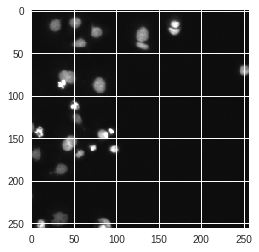

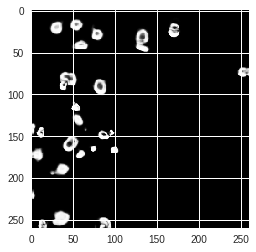

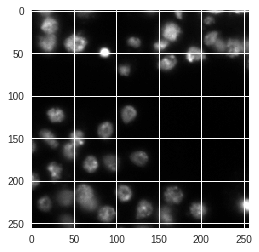

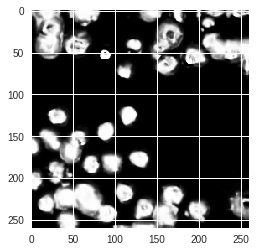

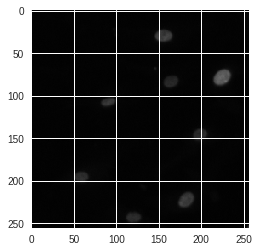

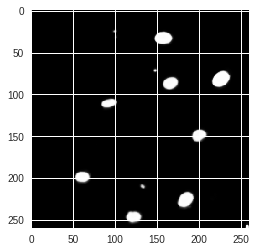

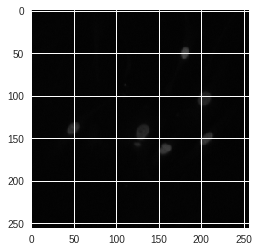

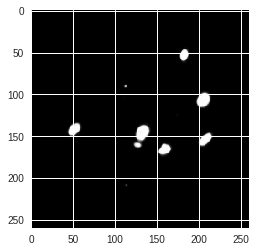

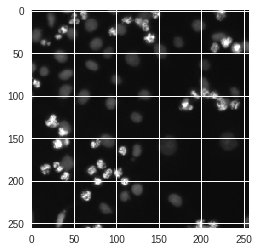

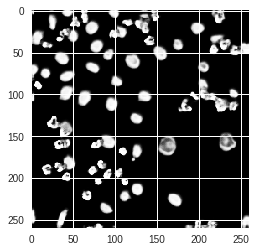

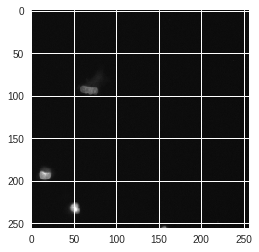

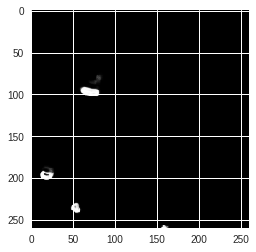

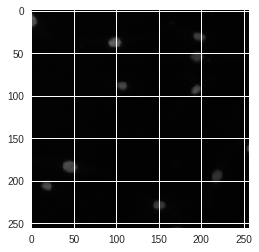

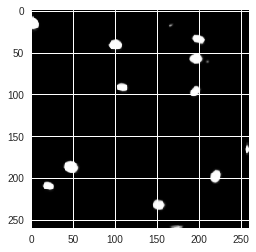

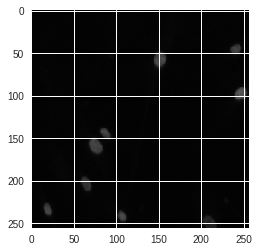

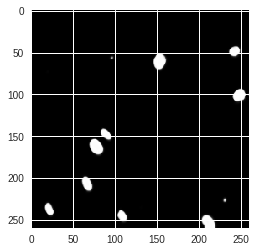

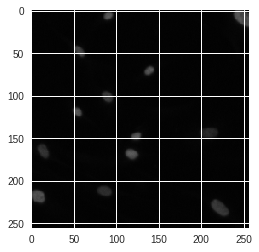

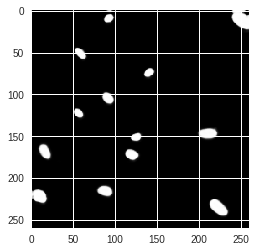

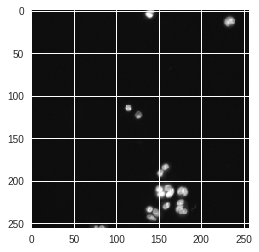

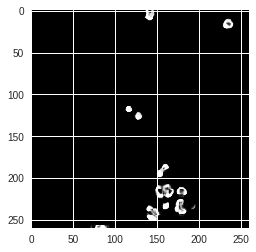

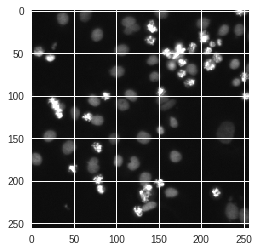

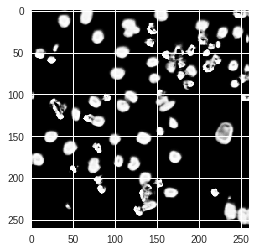

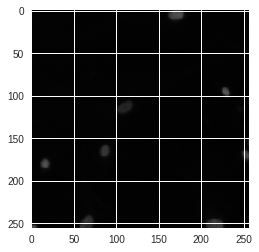

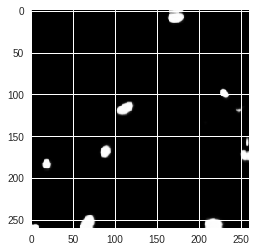

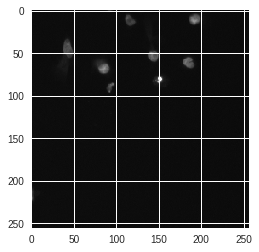

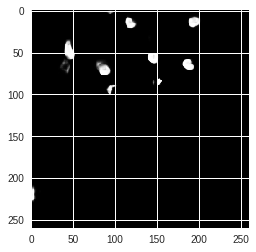

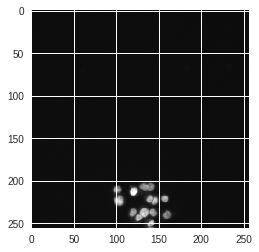

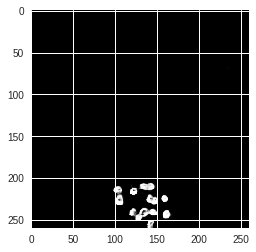

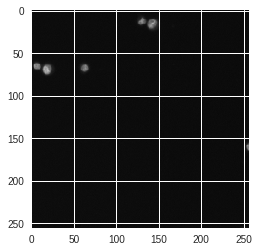

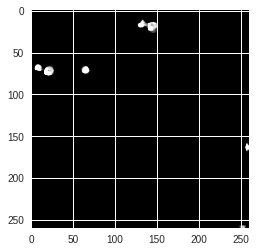

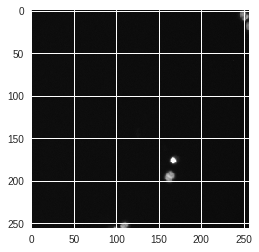

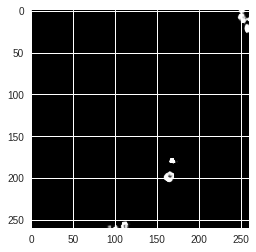

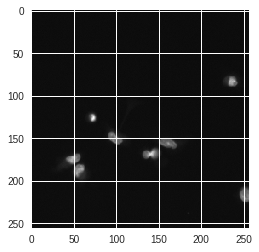

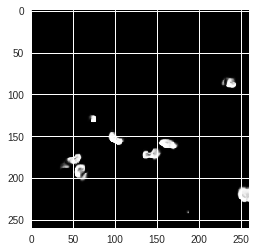

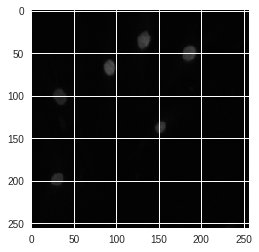

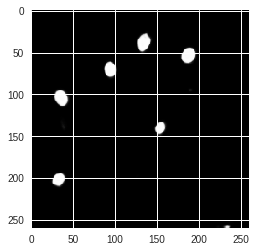

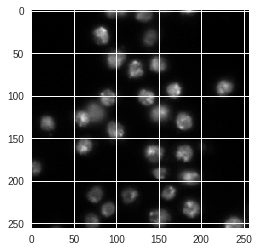

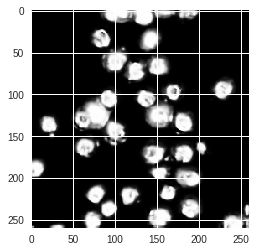

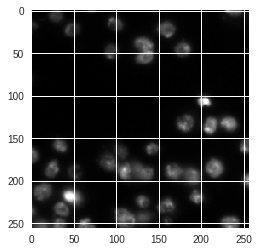

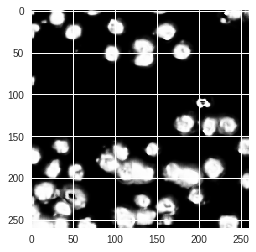

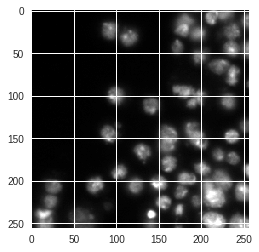

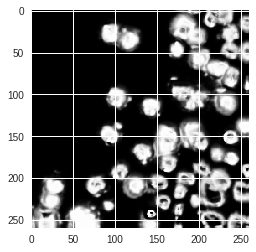

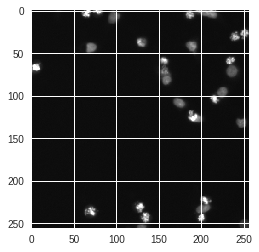

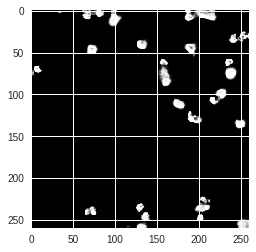

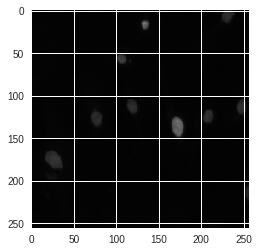

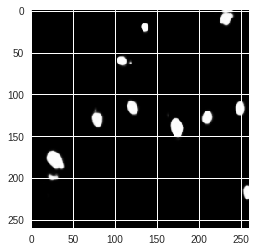

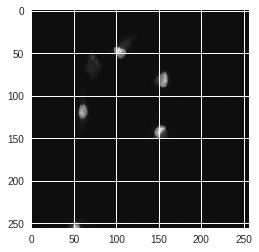

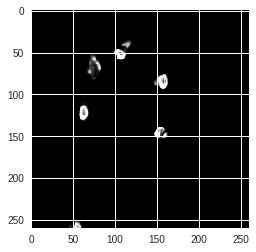

In [41]:
"""test"""
# from cs231n assignment
def sigmoid(x):
    """
    A numerically stable version of the logistic sigmoid function.
    """
    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)
  
ckpt_point = 1100
batch_size = 1
show_img_every = 1

# filter out 256x256 images to test
from scipy.ndimage import imread
TEST_IMAGE_IDS = []
for img_name in utils.TEST_IMAGE_IDS:
  h,w,_ = imread(utils.TEST_DIR +img_name + ".png").shape
  if h == 256 and w == 256:
    TEST_IMAGE_IDS.append(img_name)
init = tf.global_variables_initializer()
saver = tf.train.Saver(tf.global_variables())
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.Saver()
    saver.restore(sess, '/content/drive/Colab Notebooks/Kaggle_2018/ckpt/u-net_sigmoid_v0.1.ckpt-' + str(ckpt_point))
    for img_name in TEST_IMAGE_IDS:
      print("===============================================")
      origin = imread(utils.TEST_DIR + img_name + ".png")
      plt.imshow(origin)
      plt.show()
      tmp1 = utils.extend_sides(origin)
      tmp2 = np.transpose(tmp1, (2, 0, 1)) # CxHxW
      tmp3 = tmp2[:3,:,:]
      tmp4 = np.expand_dims(tmp3, axis=-1)
      inference_logits = sess.run(logits, \
            feed_dict={x: tmp4 })
      inference_logits = sigmoid(inference_logits)
      plt.imshow(np.transpose(inference_logits.squeeze(), (1,2,0)))
      plt.show()

INFO:tensorflow:Restoring parameters from /content/drive/Colab Notebooks/Kaggle_2018/ckpt/u-net_sigmoid256x256_v0.1.ckpt-200


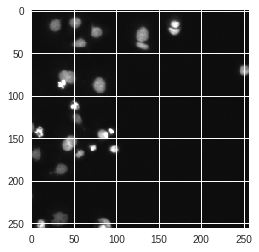

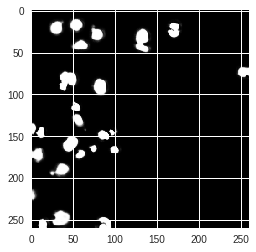

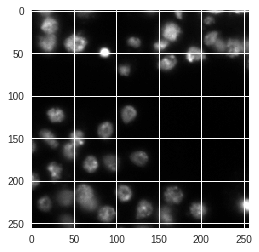

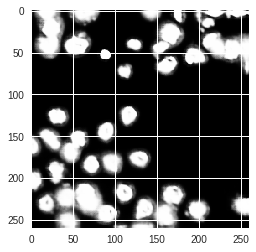

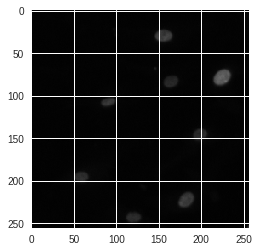

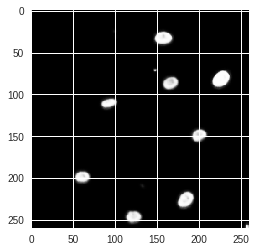

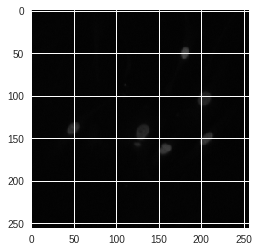

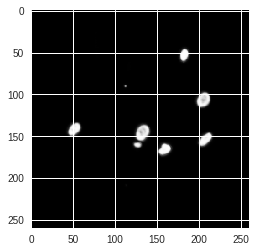

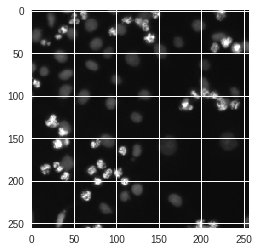

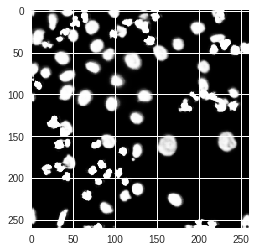

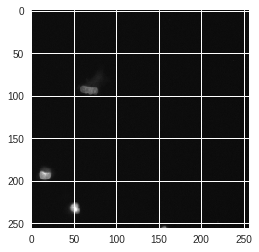

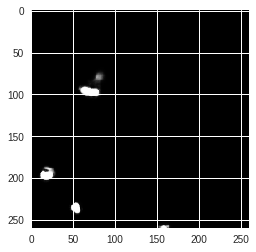

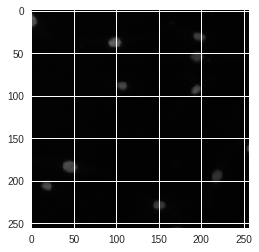

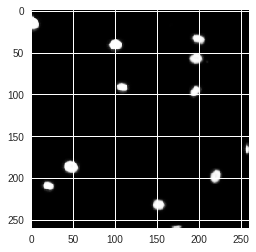

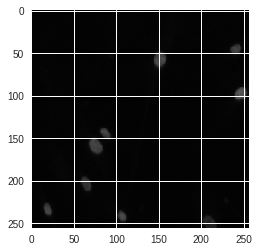

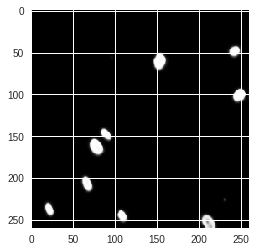

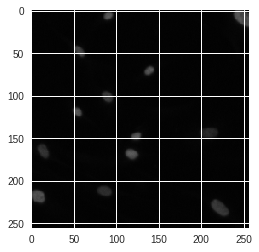

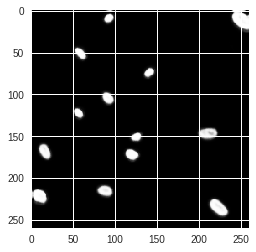

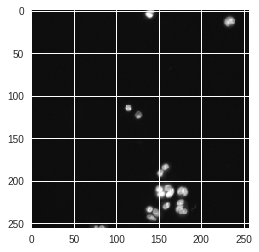

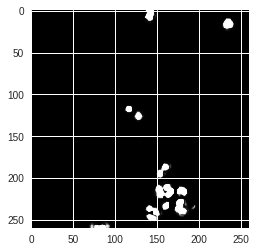

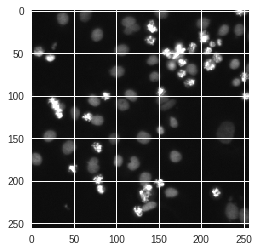

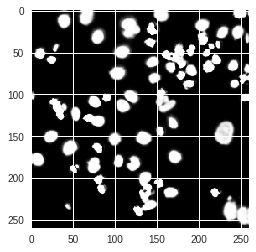

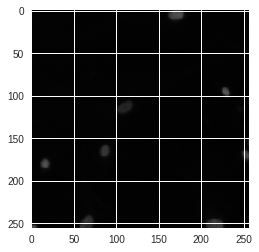

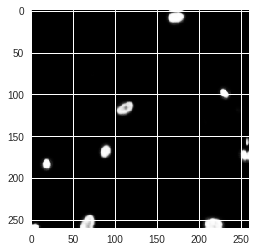

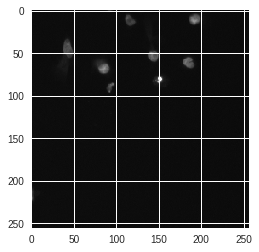

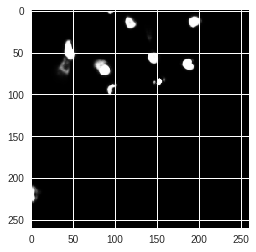

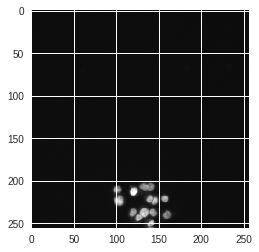

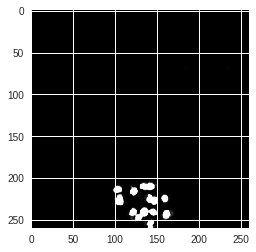

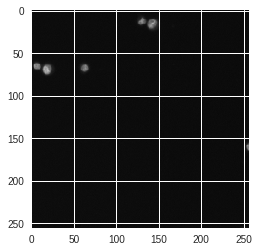

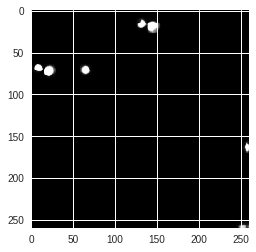

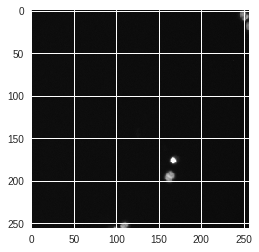

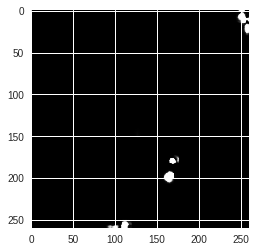

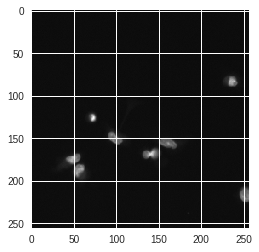

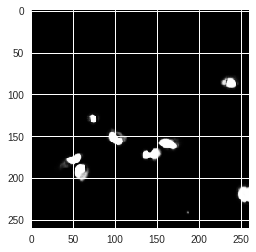

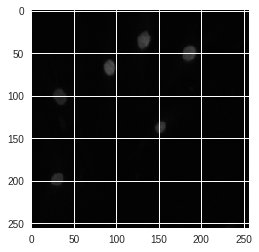

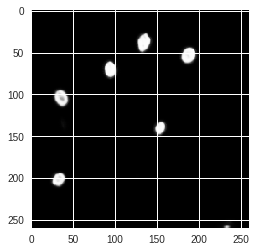

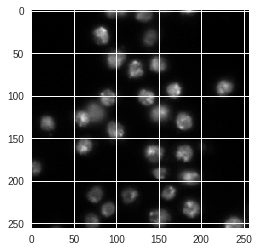

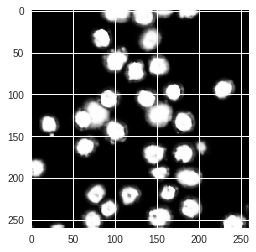

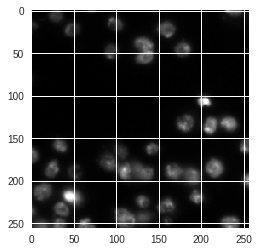

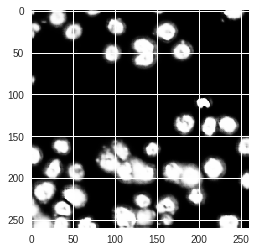

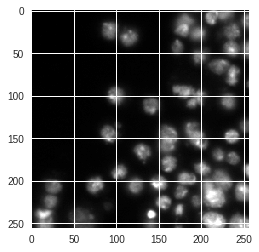

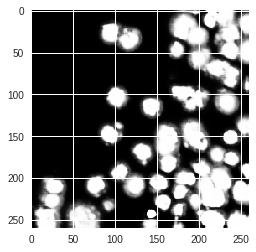

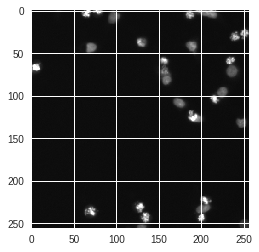

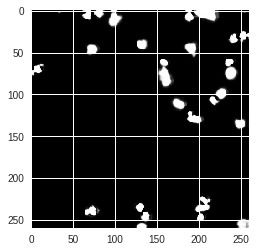

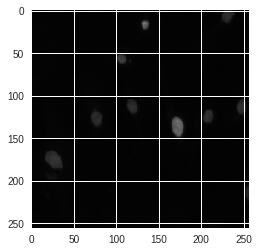

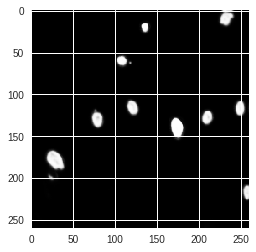

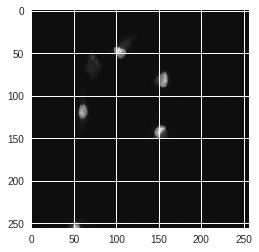

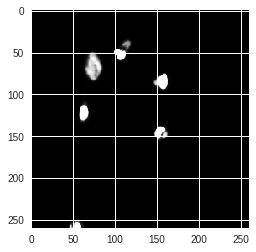

In [10]:
"""test"""
# from cs231n assignment
def sigmoid(x):
    """
    A numerically stable version of the logistic sigmoid function.
    """
    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)
  
ckpt_point = 200
batch_size = 1
show_img_every = 1

# filter out 256x256 images to test
from scipy.ndimage import imread
TEST_IMAGE_IDS = []
for img_name in utils.TEST_IMAGE_IDS:
  h,w,_ = imread(utils.TEST_DIR +img_name + ".png").shape
  if h == 256 and w == 256:
    TEST_IMAGE_IDS.append(img_name)
init = tf.global_variables_initializer()
saver = tf.train.Saver(tf.global_variables())
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.Saver()
    saver.restore(sess, '/content/drive/Colab Notebooks/Kaggle_2018/ckpt/u-net_sigmoid256x256_v0.1.ckpt-' + str(ckpt_point))
    for img_name in TEST_IMAGE_IDS:
      print("===============================================")
      origin = imread(utils.TEST_DIR + img_name + ".png")
      plt.imshow(origin)
      plt.show()
      tmp1 = utils.extend_sides(origin)
      tmp2 = np.transpose(tmp1, (2, 0, 1)) # CxHxW
      tmp3 = tmp2[:3,:,:]
      tmp4 = np.expand_dims(tmp3, axis=-1)
      inference_logits = sess.run(logits, \
            feed_dict={x: tmp4 })
      inference_logits = sigmoid(inference_logits)
      plt.imshow(np.transpose(inference_logits.squeeze(), (1,2,0)))
      plt.show()

In [0]:
"""
conclution:
- sigmoid binary loss better than softmax binary loss
- adam optimizer better than SGD
- 256x256 model better than general model on 256x256 test data
"""